In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate
from functions_folder.nn_model_simplex import *

### Short

In [3]:
# Data
mimic_data = pd.read_csv('mimic_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]
#preprocessing_data = hold_out_data
preprocessing_data.drop(columns=['iv_treatment_length'], inplace=True)
preprocessing_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure diastolic0,blood pressure diastolic1,blood pressure diastolic2,blood pressure diastolic3,blood pressure diastolic4,...,temperature14_current_stay_difference,temperature15_current_stay_difference,temperature16_current_stay_difference,temperature17_current_stay_difference,temperature18_current_stay_difference,temperature19_current_stay_difference,temperature20_current_stay_difference,temperature21_current_stay_difference,temperature_mean_current_stay_difference,temperature_std_current_stay_difference
0,39409066.0,2137-05-22,1.0,1.0,0,0.575521,0.519798,0.272727,0.700000,0.0,...,0.6,0.710059,0.600000,0.350276,-1.000000,-1.000000,0.467482,0.4,0.365151,0.075809
1,39409066.0,2137-05-23,1.0,1.0,0,0.448568,0.454810,0.454545,0.411765,0.0,...,0.4,0.410488,0.600000,0.551909,0.500693,0.439452,0.565014,0.4,0.482215,0.321606
2,30322661.0,2169-10-09,1.0,NaN,0,0.432292,0.446094,0.909091,0.304348,0.0,...,0.4,0.396435,0.600000,0.437195,0.526688,0.561250,0.666566,0.4,0.432688,0.363971
3,30322661.0,2169-10-10,1.0,1.0,0,0.361979,0.375081,0.545455,0.304348,0.0,...,0.4,0.396435,0.600000,0.437195,0.526688,0.561250,0.666566,0.4,0.432688,0.363971
4,30322661.0,2169-10-11,1.0,1.0,0,0.397135,0.378309,0.181818,0.500000,0.0,...,1.0,0.388391,0.642857,0.437195,0.526688,0.561250,0.358257,1.0,0.432688,0.664467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14515,37575956.0,2153-02-15,1.0,1.0,0,0.479167,0.536475,0.090909,0.875000,0.0,...,0.6,0.568117,0.600000,0.479335,-1.000000,-1.000000,0.454375,0.4,0.295362,0.681000
14516,37575956.0,2153-02-16,1.0,1.0,0,0.522135,0.525500,0.272727,1.000000,0.0,...,0.6,0.568117,0.600000,0.479335,-1.000000,-1.000000,0.454375,0.4,0.295362,0.681000
14517,37540542.0,2161-05-10,1.0,NaN,0,0.253906,0.237573,0.090909,-1.000000,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
14518,37540542.0,2161-05-11,1.0,1.0,0,0.397135,0.370562,0.363636,0.304348,0.0,...,0.6,0.562664,0.528571,-1.000000,-1.000000,-1.000000,-1.000000,0.4,0.234579,0.425554


In [4]:
all_shap_importance = pd.read_csv('all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
preprocessing_data = preprocessing_data[shap_list]
preprocessing_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure systolic17_current_stay,heart rate17,respiratory rate11_current_stay,blood pressure mean11_current_stay,o2 saturation pulseoxymetry3_current_stay,...,blood pressure systolic12_current_stay,o2 saturation pulseoxymetry1_current_stay_difference,gcs - verbal response14_current_stay,temperature7_current_stay,temperature6_current_stay_difference,respiratory rate3,heart rate21_current_stay,o2 saturation pulseoxymetry7_difference,gcs - verbal response2_difference,heart rate8
0,39409066.0,2137-05-22,1.0,1.0,0,0.966557,-1.000000,0.761556,0.762332,1.000000,...,0.222222,0.542862,0.0,0.000000e+00,0.4,0.633333,0.000000,0.491376,-1.0,0.384615
1,39409066.0,2137-05-23,1.0,1.0,0,0.431357,0.343572,0.126674,0.539524,0.573477,...,0.333333,0.599999,0.0,1.083738e-28,0.4,0.745098,0.111111,0.279022,-1.0,0.615385
2,30322661.0,2169-10-09,1.0,NaN,0,0.414066,0.230392,0.095854,0.400227,0.583127,...,0.111111,0.599999,0.0,9.099612e-29,0.4,0.527778,0.148148,0.364522,-1.0,0.076923
3,30322661.0,2169-10-10,1.0,1.0,0,0.327966,0.221895,0.046076,0.280141,0.460829,...,0.333333,0.599999,0.0,0.000000e+00,0.4,0.275362,0.259259,0.364522,-1.0,0.153846
4,30322661.0,2169-10-11,1.0,1.0,0,0.248910,0.521848,0.032439,0.198931,0.430108,...,0.333333,0.599999,0.0,1.622159e-01,0.4,0.452381,0.592593,0.571676,-1.0,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14515,37575956.0,2153-02-15,1.0,1.0,0,0.988171,-1.000000,0.953186,0.569251,-1.000000,...,0.000000,0.142857,-1.0,-1.000000e+00,0.4,0.791667,0.000000,0.439876,0.0,0.230769
14516,37575956.0,2153-02-16,1.0,1.0,0,0.626321,-1.000000,0.166640,0.800980,0.774194,...,0.111111,0.142857,-1.0,-1.000000e+00,0.4,0.904762,0.111111,0.439876,0.0,0.538462
14517,37540542.0,2161-05-10,1.0,NaN,0,0.968004,-1.000000,0.761556,0.718315,-1.000000,...,0.111111,-1.000000,-1.0,-1.000000e+00,-1.0,-1.000000,0.000000,-1.000000,-1.0,-1.000000
14518,37540542.0,2161-05-11,1.0,1.0,0,0.606376,0.521273,0.387155,0.412453,0.564516,...,0.333333,0.085715,0.0,2.895331e-29,-1.0,0.263889,0.259259,-1.000000,-1.0,0.307692


In [5]:
individual = '110111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

In [6]:
stays = preprocessing_data['stay_id'].unique()
import random
random.Random(5).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
#random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

X_data = preprocessing_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([preprocessing_data[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
valid_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(valid_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

In [7]:
# Oversampling train set
from typing import Counter
import imblearn
from imblearn.over_sampling import SMOTE
# Split X y
train_data_X = train_data.drop(columns=['stay_id', 'po_flag'])
train_data_y = train_data['po_flag']
Counter(train_data_y)
oversample = SMOTE()
train_data_X, train_data_y = oversample.fit_resample(train_data_X, train_data_y)
Counter(train_data_y)
train_data_y = pd.DataFrame(train_data_y, columns=['po_flag'])
train_data_y['stay_id'] = 'x'
train_data = pd.concat([train_data_y, train_data_X], axis=1)
train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

Counter({0: 8578, 1: 1629})

Counter({0: 8578, 1: 8578})

In [ ]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Define batch size 
batch_size = 256

# Define dataloaders
train_dataset = MIMICDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)

valid_dataset = MIMICDataset(valid_data)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

# Define dual_catagorial
dual_catagorial = False

# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

# Initializing the weights of our model.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Calculate the number of trainable parameters in the model.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# Define optimizer and learning_rate
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Define how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Define epochs and clip
N_EPOCHS = 10 #7 #20
CLIP = 1

# Run
best_valid_loss = float('inf')
best_select_auroc = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_accuracy, train_auroc, train_predictions, train_labels = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('BEST VALID LOSS')

    if select_auroc > best_select_auroc:
        best_valid_auroc = valid_auroc
        print('UPDATED BEST MODEL')
        #torch.save(model.state_dict(), 'optuna_switch_model_short.pt')


    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss)}')
    print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss)}')
    if valid_loss > train_loss:
        print('Val. Loss >  Train Loss, overfitting')
    elif train_loss > valid_loss:
        print('Train. Loss >  Val Loss, underfitting')
    else:
        print('Train. Loss =  Val Loss')

    print('Train accuracy result:', train_accuracy)
    print('Train AUROC result:', train_auroc)
    print(np.unique(train_predictions.round(), return_counts=True))
    print(np.unique(train_labels.round(), return_counts=True))
    print('Validation accuracy result:', valid_accuracy)
    print('Validation AUROC result:', valid_auroc)
    print(np.unique(valid_predictions.round(), return_counts=True))
    print(np.unique(valid_labels.round(), return_counts=True))

    torch.set_printoptions(edgeitems=10)
    #print('train_predictions', train_predictions)
    #print('train_labels', train_labels)
    #print('valid_predictions', valid_predictions)
    #print('valid_labels', valid_labels)

# -----------------------------
# Evaluate best model on test set
# -----------------------------

model.load_state_dict(torch.load('optuna_switch_model_short.pt'))

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

confusion_matrix(test_labels.round(), test_predictions.round())

In [8]:
# -----------------------------
# Evaluate best model on test set
# -----------------------------
# Hyperparameters
INPUT_DIM = 5
OUTPUT_DIM = 1
HID_DIM = 512 
HID_DIM2 = 16 
DROPOUT = 0.4

# Define model
model = Model_simplex_short(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, DROPOUT).to(device)

model.load_state_dict(torch.load('optuna_switch_model_short.pt'))

# Define batch size 
batch_size = 256

test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

# Define loss
criterion = nn.BCEWithLogitsLoss()

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

confusion_matrix(test_labels.round(), test_predictions.round())

<All keys matched successfully>

100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


| Test Loss: 0.4500347408983443 | Test PPL: 1.5683666710108095 |
Test accuracy result: 0.7488563586459286
Test AUROC result: 0.7996747265400115
(array([0., 1.], dtype=float32), array([1345,  841]))
(array([0., 1.], dtype=float32), array([1800,  386]))
test_predictions [1.2367612e-04 8.9396268e-02 6.4385659e-03 ... 1.1921388e-03 1.1397332e-01
 3.3837751e-01]
test_labels [0. 1. 0. ... 0. 0. 0.]


array([[1298,  502],
       [  47,  339]])

In [9]:
valid_dataset = MIMICDataset(valid_data)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

print(f'\n| Valid Loss: {valid_loss} | Valid PPL: {math.exp(valid_loss)} |')
print('Valid accuracy result:', valid_accuracy)
print('Valid AUROC result:', valid_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(valid_predictions.round(), return_counts=True))
print(np.unique(valid_labels.round(), return_counts=True))
print('valid_predictions', valid_predictions)
print('valid_labels', valid_labels)

confusion_matrix(valid_labels.round(), valid_predictions.round())

100%|██████████| 9/9 [00:01<00:00,  4.89it/s]


| Valid Loss: 0.43259630931748283 | Valid PPL: 1.5412539052566654 |
Valid accuracy result: 0.7564645039962389
Valid AUROC result: 0.7998971337075618
(array([0., 1.], dtype=float32), array([1341,  786]))
(array([0., 1.], dtype=float32), array([1761,  366]))
valid_predictions [1.2635910e-04 1.8087743e-02 1.3094376e-01 ... 7.2052074e-04 1.9984114e-01
 3.2997438e-01]
valid_labels [0. 0. 0. ... 0. 0. 0.]


array([[1292,  469],
       [  49,  317]])

Cut off point

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(valid_labels, valid_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5427614

In [17]:
j_scores = tpr-fpr
j_ordered = sorted(zip(j_scores,thresholds))
j_ordered[-1][1]

0.5427614

CUT-OFF:
x           1.000000
y           1.000000
proba       0.542761
tpr         0.852459
fpr         0.249858
youden_j    0.602601
Name: 0, dtype: float64


Text(0.5, 1.0, 'ROC curve')

<AxesSubplot:title={'center':"Youden's index"}, xlabel='Youden j', ylabel='Predicted Probabilities'>

'df_test.plot(\n    x="x", y="proba", ax=ax[2], \n    ylabel="Predicted Probabilities", xlabel="X Feature",\n    title="Cut-Off", legend=False\n)\nax[2].axvline(cut_off.x, color="k", ls="--")\nax[2].axhline(cut_off.proba, color="k", ls="--")'

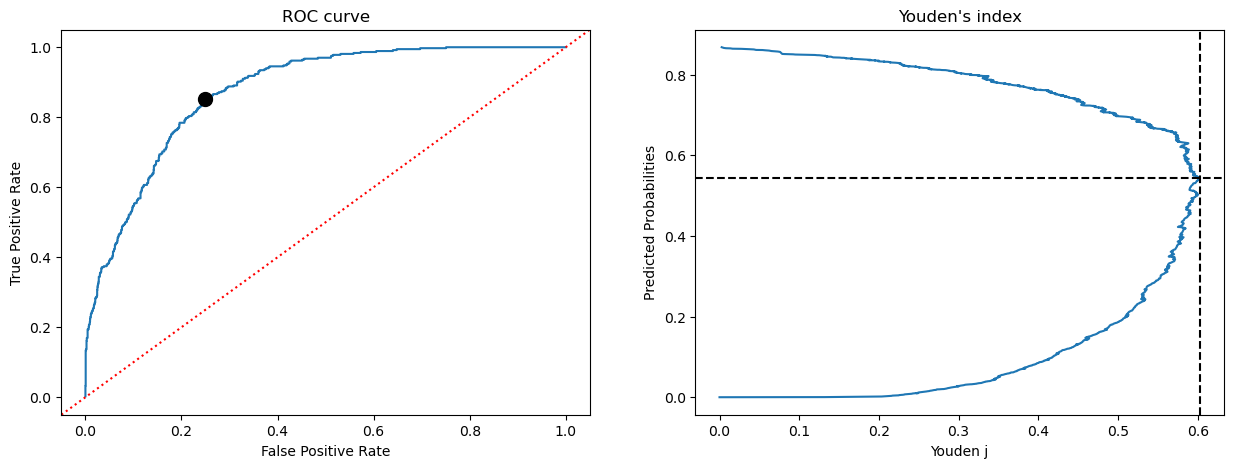

In [59]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
# compute FPR and TPR from y test set and predicted probabilities
fpr, tpr, thresholds = roc_curve(
    valid_labels, valid_predictions, drop_intermediate=False)
# compute ROC AUC
roc_auc = auc(fpr, tpr)
# init a dataframe for results
df_test = pd.DataFrame({
    "x": valid_labels.flatten(),
    "y": valid_labels,
    "proba": valid_predictions
})
# sort it by predicted probabilities
# because thresholds[1:] = y_proba[::-1]
df_test.sort_values(by="proba", inplace=True)
df_test.drop_duplicates(subset=['proba'], inplace=True)
# add reversed TPR and FPR
df_test["tpr"] = tpr[1:][::-1]
df_test["fpr"] = fpr[1:][::-1]
# optional: add thresholds to check
#df_test["thresholds"] = thresholds[1:][::-1]
# add Youden's j index
df_test["youden_j"] = df_test.tpr - df_test.fpr
# define the cut_off and diplay it
cut_off = df_test.sort_values(
    by="youden_j", ascending=False, ignore_index=True).iloc[0]
print("CUT-OFF:")
print(cut_off)

# plot everything
#with plt.style.context("bmh"):
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

RocCurveDisplay(
    fpr=df_test.fpr, tpr=df_test.tpr,
    ).plot(ax=ax[0])
ax[0].set_title("ROC curve")
ax[0].axline(xy1=(0,0), slope=1, color="r", ls=":")
ax[0].plot(cut_off.fpr, cut_off.tpr, 'ko', ms=10)

df_test.plot(
    x="youden_j", y="proba", ax=ax[1], 
    ylabel="Predicted Probabilities", xlabel="Youden j",
    title="Youden's index", legend=False
)
ax[1].axvline(cut_off.youden_j, color="k", ls="--")
ax[1].axhline(cut_off.proba, color="k", ls="--")

'''df_test.plot(
    x="x", y="proba", ax=ax[2], 
    ylabel="Predicted Probabilities", xlabel="X Feature",
    title="Cut-Off", legend=False
)
ax[2].axvline(cut_off.x, color="k", ls="--")
ax[2].axhline(cut_off.proba, color="k", ls="--")'''

plt.show()

In [24]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve


In [65]:
# Function: Finding thresholds
def _threshold_finder(y_true, y_predict_proba):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title('Sensitivity and specificity scores versus cut-off threshold', fontsize = 12)
    plt.annotate(text=F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.2f}", fontsize = 12, xy=(0.32, 0.925), xycoords='axes fraction')
    #plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    #plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title('Precision, Recall and F1-Score scores versus cut-off threshold', fontsize = 12)
    #plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.annotate(text=F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.2f}", fontsize = 12, xy=(0.32, 0.925), xycoords='axes fraction')
    plt.show()

In [26]:
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

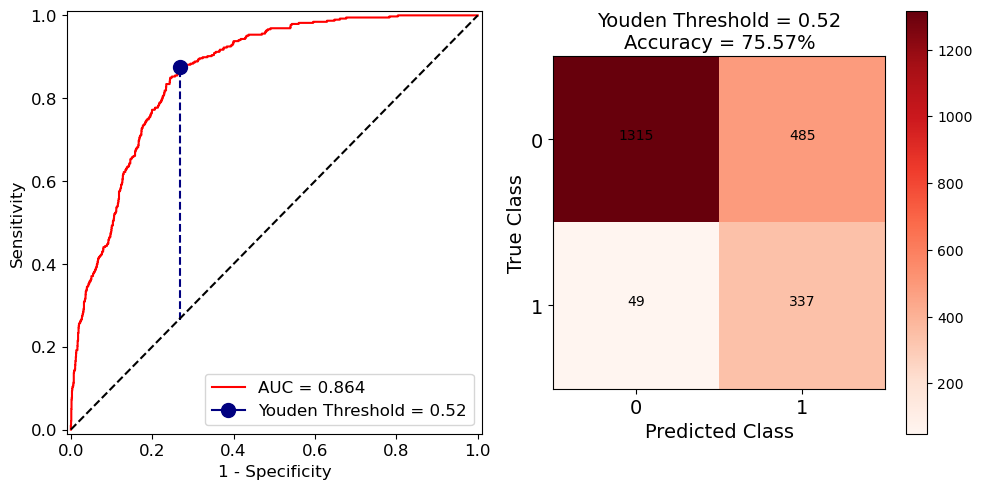

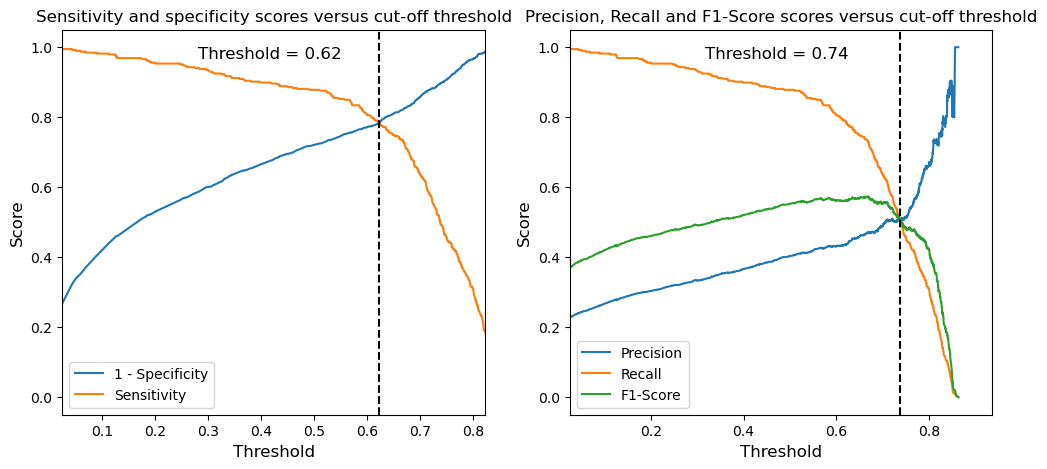

In [66]:
_threshold_finder(test_labels, test_predictions)

In [13]:
def new_threshold_performance(labels, predictions, lower_bound=0.54, upper_bound=0.74):
    lower_bound_predictions = [1 if a_ >= lower_bound else 0 for a_ in predictions]
    #print(lower_bound_predictions)
    #lower_bound_predictions = predictions[predictions >= lower_bound] = 1 else 0
    #lower_bound_predictions = lower_bound_predictions[lower_bound_predictions < lower_bound] = 0
    lower_bound_auroc = roc_auc_score(labels, lower_bound_predictions)
    upper_bound_predictions = [1 if a_ >= upper_bound else 0 for a_ in predictions]
    #print(upper_bound_predictions)
    print(np.unique(lower_bound_predictions, return_counts=True))
    print(np.unique(upper_bound_predictions, return_counts=True))
    #upper_bound_predictions = predictions[predictions >= upper_bound] = 1
    #upper_bound_predictions = upper_bound_predictions[upper_bound_predictions < upper_bound] = 0
    upper_bound_auroc = roc_auc_score(labels, upper_bound_predictions)
    return lower_bound_auroc, upper_bound_auroc, lower_bound_predictions, upper_bound_predictions

In [14]:
lower_bound_auroc, upper_bound_auroc, lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_performance(test_labels, test_predictions, optimal_threshold, 0.736) #optimal_threshold
lower_bound_auroc, upper_bound_auroc
test_auroc

(array([0, 1]), array([1390,  796]))
(array([0, 1]), array([1797,  389]))


(0.7980166954519285, 0.7034211283822682)

0.7996747265400115

### Long

In [5]:
# Data
mimic_data = pd.read_csv('VSCode_projects/stop/csv/mimic_renewed_data.csv')


# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = mimic_data['stay_id'].unique()
import random
random.Random(0).shuffle(stays)
model_data2 = mimic_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]
#preprocessing_data = hold_out_data
preprocessing_data.drop(columns=['iv_treatment_length'], inplace=True)
preprocessing_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure diastolic0,blood pressure diastolic1,blood pressure diastolic2,blood pressure diastolic3,blood pressure diastolic4,...,temperature14_current_stay_difference,temperature15_current_stay_difference,temperature16_current_stay_difference,temperature17_current_stay_difference,temperature18_current_stay_difference,temperature19_current_stay_difference,temperature20_current_stay_difference,temperature21_current_stay_difference,temperature_mean_current_stay_difference,temperature_std_current_stay_difference
0,39409066.0,2137-05-22,1.0,1.0,0,0.575521,0.519798,0.272727,0.700000,0.0,...,0.6,0.710059,0.600000,0.350276,-1.000000,-1.000000,0.467482,0.4,0.365151,0.075809
1,39409066.0,2137-05-23,1.0,1.0,0,0.448568,0.454810,0.454545,0.411765,0.0,...,0.4,0.410488,0.600000,0.551909,0.500693,0.439452,0.565014,0.4,0.482215,0.321606
2,30322661.0,2169-10-09,1.0,NaN,0,0.432292,0.446094,0.909091,0.304348,0.0,...,0.4,0.396435,0.600000,0.437195,0.526688,0.561250,0.666566,0.4,0.432688,0.363971
3,30322661.0,2169-10-10,1.0,1.0,0,0.361979,0.375081,0.545455,0.304348,0.0,...,0.4,0.396435,0.600000,0.437195,0.526688,0.561250,0.666566,0.4,0.432688,0.363971
4,30322661.0,2169-10-11,1.0,1.0,0,0.397135,0.378309,0.181818,0.500000,0.0,...,1.0,0.388391,0.642857,0.437195,0.526688,0.561250,0.358257,1.0,0.432688,0.664467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14515,37575956.0,2153-02-15,1.0,1.0,0,0.479167,0.536475,0.090909,0.875000,0.0,...,0.6,0.568117,0.600000,0.479335,-1.000000,-1.000000,0.454375,0.4,0.295362,0.681000
14516,37575956.0,2153-02-16,1.0,1.0,0,0.522135,0.525500,0.272727,1.000000,0.0,...,0.6,0.568117,0.600000,0.479335,-1.000000,-1.000000,0.454375,0.4,0.295362,0.681000
14517,37540542.0,2161-05-10,1.0,NaN,0,0.253906,0.237573,0.090909,-1.000000,0.0,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
14518,37540542.0,2161-05-11,1.0,1.0,0,0.397135,0.370562,0.363636,0.304348,0.0,...,0.6,0.562664,0.528571,-1.000000,-1.000000,-1.000000,-1.000000,0.4,0.234579,0.425554


In [6]:
all_shap_importance = pd.read_csv('ts/stop/csv/renewed_all_shap_importance.csv')

shap_list = all_shap_importance[all_shap_importance['feature_importance_vals'] >= 0.5].col_name.unique().tolist()
shap_list = ['stay_id', 'date', 'iv_flag', 'first_po_flag', 'po_flag'] + shap_list
preprocessing_data = preprocessing_data[shap_list]
preprocessing_data

,stay_id,date,iv_flag,first_po_flag,po_flag,blood pressure systolic17_current_stay,heart rate17,respiratory rate11_current_stay,blood pressure mean11_current_stay,o2 saturation pulseoxymetry3_current_stay,...,blood pressure systolic12_current_stay,o2 saturation pulseoxymetry1_current_stay_difference,gcs - verbal response14_current_stay,temperature7_current_stay,temperature6_current_stay_difference,respiratory rate3,heart rate21_current_stay,o2 saturation pulseoxymetry7_difference,gcs - verbal response2_difference,heart rate8
0,39409066.0,2137-05-22,1.0,1.0,0,0.966557,-1.000000,0.761556,0.762332,1.000000,...,0.222222,0.542862,0.0,0.000000e+00,0.4,0.633333,0.000000,0.491376,-1.0,0.384615
1,39409066.0,2137-05-23,1.0,1.0,0,0.431357,0.343572,0.126674,0.539524,0.573477,...,0.333333,0.599999,0.0,1.083738e-28,0.4,0.745098,0.111111,0.279022,-1.0,0.615385
2,30322661.0,2169-10-09,1.0,NaN,0,0.414066,0.230392,0.095854,0.400227,0.583127,...,0.111111,0.599999,0.0,9.099612e-29,0.4,0.527778,0.148148,0.364522,-1.0,0.076923
3,30322661.0,2169-10-10,1.0,1.0,0,0.327966,0.221895,0.046076,0.280141,0.460829,...,0.333333,0.599999,0.0,0.000000e+00,0.4,0.275362,0.259259,0.364522,-1.0,0.153846
4,30322661.0,2169-10-11,1.0,1.0,0,0.248910,0.521848,0.032439,0.198931,0.430108,...,0.333333,0.599999,0.0,1.622159e-01,0.4,0.452381,0.592593,0.571676,-1.0,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14515,37575956.0,2153-02-15,1.0,1.0,0,0.988171,-1.000000,0.953186,0.569251,-1.000000,...,0.000000,0.142857,-1.0,-1.000000e+00,0.4,0.791667,0.000000,0.439876,0.0,0.230769
14516,37575956.0,2153-02-16,1.0,1.0,0,0.626321,-1.000000,0.166640,0.800980,0.774194,...,0.111111,0.142857,-1.0,-1.000000e+00,0.4,0.904762,0.111111,0.439876,0.0,0.538462
14517,37540542.0,2161-05-10,1.0,NaN,0,0.968004,-1.000000,0.761556,0.718315,-1.000000,...,0.111111,-1.000000,-1.0,-1.000000e+00,-1.0,-1.000000,0.000000,-1.000000,-1.0,-1.000000
14518,37540542.0,2161-05-11,1.0,1.0,0,0.606376,0.521273,0.387155,0.412453,0.564516,...,0.333333,0.085715,0.0,2.895331e-29,-1.0,0.263889,0.259259,-1.000000,-1.0,0.307692


In [7]:
individual = '110111100011000100010101000000001011100101111010000000001100010100101000011100000010101110001'

In [8]:
stays = preprocessing_data['stay_id'].unique()
import random
random.Random(5).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for preprocessing_data
#random.Random(2).shuffle(stays) # Note changed random split to 5 so split between po_flag is similar for val and test sets - use this for hold_out_data

X_data = preprocessing_data.drop(columns=['stay_id', 'po_flag', 'date', 'iv_flag', 'first_po_flag'])
# Filter for features in this individual
X_data = X_data.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
model_data = pd.concat([preprocessing_data[['stay_id', 'po_flag']], X_data], axis=1)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = model_data2[model_data2['stay_id'].isin(train_stays)]
valid_data = model_data2[model_data2['stay_id'].isin(validation_stays)]
test_data = model_data2[model_data2['stay_id'].isin(test_stays)]

In [7]:
# Oversampling train set
from typing import Counter
import imblearn
from imblearn.over_sampling import SMOTE
# Split X y
train_data_X = train_data.drop(columns=['stay_id', 'po_flag'])
train_data_y = train_data['po_flag']
Counter(train_data_y)
oversample = SMOTE()
train_data_X, train_data_y = oversample.fit_resample(train_data_X, train_data_y)
Counter(train_data_y)
train_data_y = pd.DataFrame(train_data_y, columns=['po_flag'])
train_data_y['stay_id'] = 'x'
train_data = pd.concat([train_data_y, train_data_X], axis=1)
train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

Counter({0: 8578, 1: 1629})

Counter({0: 8578, 1: 8578})

In [ ]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Define batch size 
batch_size = 256

# Define dataloaders
train_dataset = MIMICDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)

valid_dataset = MIMICDataset(valid_data)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

# Define dual_catagorial
dual_catagorial = False

# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

# Initializing the weights of our model.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Calculate the number of trainable parameters in the model.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# Define optimizer and learning_rate
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Define how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Define epochs and clip
N_EPOCHS = 10 #7 #20
CLIP = 1

# Run
best_valid_loss = float('inf')
best_valid_auroc = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_accuracy, train_auroc, train_predictions, train_labels = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('BEST VALID LOSS')

    if valid_auroc > best_valid_auroc:
        best_valid_auroc = valid_auroc
        print('UPDATED BEST MODEL')
        torch.save(model.state_dict(), 'optuna_switch_model_long.pt')


    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss)}')
    print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss)}')
    if valid_loss > train_loss:
        print('Val. Loss >  Train Loss, overfitting')
    elif train_loss > valid_loss:
        print('Train. Loss >  Val Loss, underfitting')
    else:
        print('Train. Loss =  Val Loss')

    print('Train accuracy result:', train_accuracy)
    print('Train AUROC result:', train_auroc)
    print(np.unique(train_predictions.round(), return_counts=True))
    print(np.unique(train_labels.round(), return_counts=True))
    print('Validation accuracy result:', valid_accuracy)
    print('Validation AUROC result:', valid_auroc)
    print(np.unique(valid_predictions.round(), return_counts=True))
    print(np.unique(valid_labels.round(), return_counts=True))

    torch.set_printoptions(edgeitems=10)
    #print('train_predictions', train_predictions)
    #print('train_labels', train_labels)
    #print('valid_predictions', valid_predictions)
    #print('valid_labels', valid_labels)

# -----------------------------
# Evaluate best model on test set
# -----------------------------

model.load_state_dict(torch.load('optuna_switch_model_long.pt'))

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

confusion_matrix(test_labels.round(), test_predictions.round())

In [9]:
# -----------------------------
# Evaluate best model on test set
# -----------------------------

model.load_state_dict(torch.load('optuna_switch_model_long.pt'))

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

confusion_matrix(test_labels.round(), test_predictions.round())

<All keys matched successfully>

100%|██████████| 9/9 [00:01<00:00,  4.54it/s]


| Test Loss: 0.4241909252272712 | Test PPL: 1.528353367143696 |
Test accuracy result: 0.7859103385178408
Test AUROC result: 0.8119991364421416
(array([0., 1.], dtype=float32), array([1446,  740]))
(array([0., 1.], dtype=float32), array([1800,  386]))
test_predictions [8.4373183e-05 1.6900912e-01 6.8859323e-03 ... 6.4553293e-05 1.2708935e-01
 2.9605985e-01]
test_labels [0. 1. 0. ... 0. 0. 0.]


array([[1389,  411],
       [  57,  329]])

In [10]:
# -----------------------------
# Evaluate best model on test set
# -----------------------------
# Hyperparameters
INPUT_DIM = 37
OUTPUT_DIM = 1
HID_DIM = 64 
HID_DIM2 = 512 
HID_DIM3 = 256 
DROPOUT = 0.5

# Define model
model = Model_simplex_long(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, DROPOUT).to(device)

model.load_state_dict(torch.load('optuna_switch_model_long.pt'))

# Define batch size 
batch_size = 256

test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

# Define loss
criterion = nn.BCEWithLogitsLoss()

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

confusion_matrix(test_labels.round(), test_predictions.round())

<All keys matched successfully>

100%|██████████| 9/9 [00:02<00:00,  3.65it/s]


| Test Loss: 0.4241909252272712 | Test PPL: 1.528353367143696 |
Test accuracy result: 0.7859103385178408
Test AUROC result: 0.8119991364421416
(array([0., 1.], dtype=float32), array([1446,  740]))
(array([0., 1.], dtype=float32), array([1800,  386]))
test_predictions [8.4373183e-05 1.6900912e-01 6.8859323e-03 ... 6.4553293e-05 1.2708935e-01
 2.9605985e-01]
test_labels [0. 1. 0. ... 0. 0. 0.]


array([[1389,  411],
       [  57,  329]])

In [11]:
valid_dataset = MIMICDataset(valid_data)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

print(f'\n| Valid Loss: {valid_loss} | Valid PPL: {math.exp(valid_loss)} |')
print('Valid accuracy result:', valid_accuracy)
print('Valid AUROC result:', valid_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(valid_predictions.round(), return_counts=True))
print(np.unique(valid_labels.round(), return_counts=True))
print('valid_predictions', valid_predictions)
print('valid_labels', valid_labels)

confusion_matrix(valid_labels.round(), valid_predictions.round())

100%|██████████| 9/9 [00:01<00:00,  4.55it/s]


| Valid Loss: 0.38761211103863186 | Valid PPL: 1.4734581352814256 |
Valid accuracy result: 0.8058298072402444
Valid AUROC result: 0.8297097401811564
(array([0., 1.], dtype=float32), array([1446,  681]))
(array([0., 1.], dtype=float32), array([1761,  366]))
valid_predictions [7.9334568e-05 6.7959032e-03 9.5612556e-02 ... 2.7857795e-03 1.2864760e-01
 6.2890142e-01]
valid_labels [0. 0. 0. ... 0. 0. 0.]


array([[1397,  364],
       [  49,  317]])

Cut off point

In [12]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5227176

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5227176

CUT-OFF:
x           1.000000
y           1.000000
proba       0.322682
tpr         0.934426
fpr         0.268030
youden_j    0.666397
Name: 0, dtype: float64


Text(0.5, 1.0, 'ROC curve')

<AxesSubplot:title={'center':"Youden's index"}, xlabel='Youden j', ylabel='Predicted Probabilities'>

'df_test.plot(\n    x="x", y="proba", ax=ax[2], \n    ylabel="Predicted Probabilities", xlabel="X Feature",\n    title="Cut-Off", legend=False\n)\nax[2].axvline(cut_off.x, color="k", ls="--")\nax[2].axhline(cut_off.proba, color="k", ls="--")'

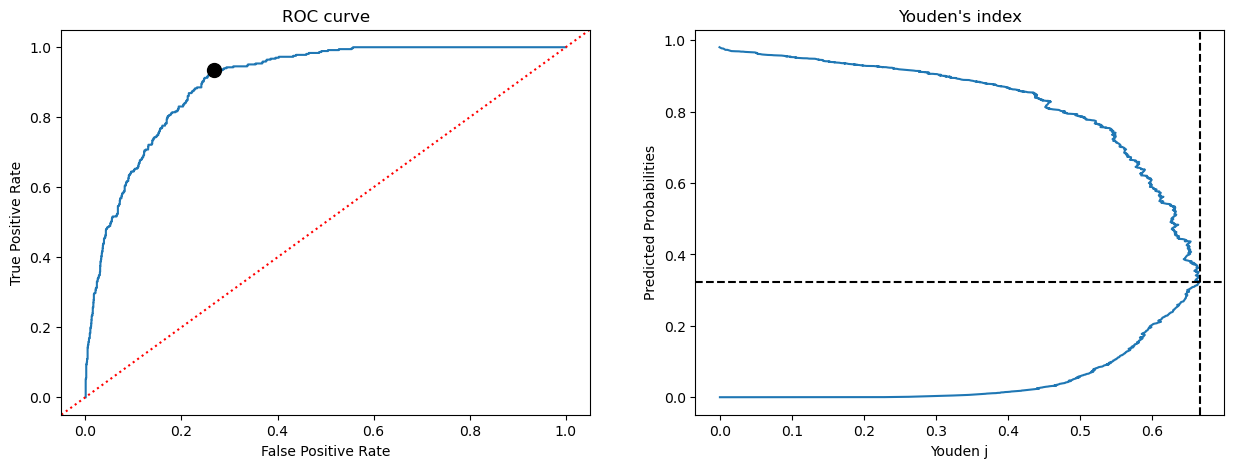

In [16]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
# compute FPR and TPR from y test set and predicted probabilities
fpr, tpr, thresholds = roc_curve(
    valid_labels, valid_predictions, drop_intermediate=False)
# compute ROC AUC
roc_auc = auc(fpr, tpr)
# init a dataframe for results
df_test = pd.DataFrame({
    "x": valid_labels.flatten(),
    "y": valid_labels,
    "proba": valid_predictions
})
# sort it by predicted probabilities
# because thresholds[1:] = y_proba[::-1]
df_test.sort_values(by="proba", inplace=True)
df_test.drop_duplicates(subset=['proba'], inplace=True)
# add reversed TPR and FPR
df_test["tpr"] = tpr[1:][::-1]
df_test["fpr"] = fpr[1:][::-1]
# optional: add thresholds to check
#df_test["thresholds"] = thresholds[1:][::-1]
# add Youden's j index
df_test["youden_j"] = df_test.tpr - df_test.fpr
# define the cut_off and diplay it
cut_off = df_test.sort_values(
    by="youden_j", ascending=False, ignore_index=True).iloc[0]
print("CUT-OFF:")
print(cut_off)

# plot everything
#with plt.style.context("bmh"):
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

RocCurveDisplay(
    fpr=df_test.fpr, tpr=df_test.tpr,
    ).plot(ax=ax[0])
ax[0].set_title("ROC curve")
ax[0].axline(xy1=(0,0), slope=1, color="r", ls=":")
ax[0].plot(cut_off.fpr, cut_off.tpr, 'ko', ms=10)

df_test.plot(
    x="youden_j", y="proba", ax=ax[1], 
    ylabel="Predicted Probabilities", xlabel="Youden j",
    title="Youden's index", legend=False
)
ax[1].axvline(cut_off.youden_j, color="k", ls="--")
ax[1].axhline(cut_off.proba, color="k", ls="--")

'''df_test.plot(
    x="x", y="proba", ax=ax[2], 
    ylabel="Predicted Probabilities", xlabel="X Feature",
    title="Cut-Off", legend=False
)
ax[2].axvline(cut_off.x, color="k", ls="--")
ax[2].axhline(cut_off.proba, color="k", ls="--")'''

plt.show()

In [19]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

In [42]:
# Function: Finding thresholds
def _threshold_finder(y_true, y_predict_proba):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title('Sensitivity and specificity scores versus cut-off threshold', fontsize = 12)
    plt.annotate(text=F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.2f}", fontsize = 12, xy=(0.32, 0.925), xycoords='axes fraction')
    #plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    #plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title('Precision, Recall and F1-Score scores versus cut-off threshold', fontsize = 12)
    #plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.annotate(text=F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.2f}", fontsize = 12, xy=(0.32, 0.925), xycoords='axes fraction')
    plt.show()

In [18]:
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

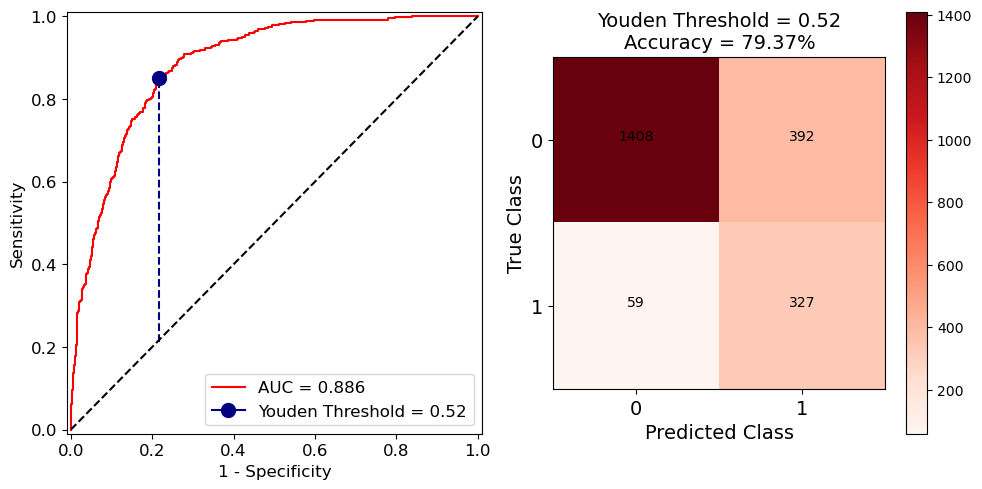

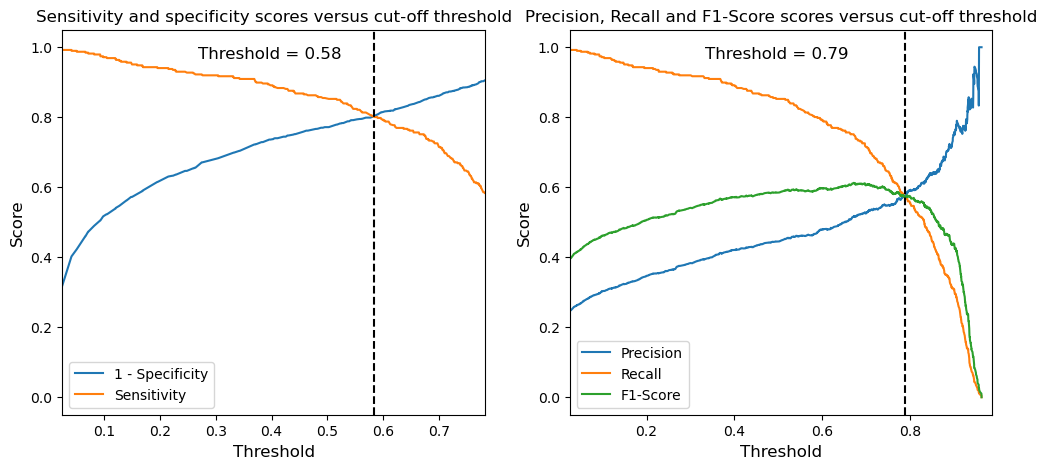

In [43]:
_threshold_finder(test_labels, test_predictions)

In [21]:
def new_threshold_fun(predictions, lower_bound=0.5227176, upper_bound=0.7876785397529602):
    lower_bound_predictions = [1 if a_ >= lower_bound else 0 for a_ in predictions]
    upper_bound_predictions = [1 if a_ >= upper_bound else 0 for a_ in predictions]
    return lower_bound_predictions, upper_bound_predictions

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

lower_bound_test_predictions, upper_bound_test_predictions = new_threshold_fun(test_predictions)

roc_auc_score(test_labels, lower_bound_test_predictions)
accuracy_score(test_labels, lower_bound_test_predictions)
precision_score(test_labels, lower_bound_test_predictions)
recall_score(test_labels, lower_bound_test_predictions)
f1_score(test_labels, lower_bound_test_predictions)
average_precision_score(test_labels, lower_bound_test_predictions)
lb_cm = confusion_matrix(test_labels, lower_bound_test_predictions)
lb_cm
tn, fp, fn, tp = lb_cm.ravel()
(tp / (tp + fn))
(fp / (fp + tn))

roc_auc_score(test_labels, upper_bound_test_predictions)
accuracy_score(test_labels, upper_bound_test_predictions)
precision_score(test_labels, upper_bound_test_predictions)
recall_score(test_labels, upper_bound_test_predictions)
f1_score(test_labels, upper_bound_test_predictions)
average_precision_score(test_labels, upper_bound_test_predictions)
ub_cm = confusion_matrix(test_labels, upper_bound_test_predictions)
ub_cm
tn, fp, fn, tp = ub_cm.ravel()
(tp / (tp + fn))
(fp / (fp + tn))

0.8146862406447898

0.7936870997255261

0.45479833101529904

0.8471502590673575

0.5918552036199094

0.41227245989909655

array([[1408,  392],
       [  59,  327]])

0.8471502590673575

0.21777777777777776

0.7407138744962579

0.8494967978042086

0.574025974025974

0.572538860103627

0.5732814526588845

0.4041325062074153

array([[1636,  164],
       [ 165,  221]])

0.572538860103627

0.09111111111111111